**Groups:**
+ *ecoli_HOGs_fullid_all* - all hierarchical orthologous groups (HOGs) with full id (**22356** groups)

    Command: **python extract_hogs.py -i ecoli_full_data/* -o ecoli_HOGs_fullid_all -g HOG --full_HOG --incl-nonPP**
    
+ *ecoli_HOGs_fullid_PP* - hierarchical orthologous groups (HOGs) with full id including only those containing at least 1 protein with polyproline motif (**6923** groups)

    Command: **python extract_hogs.py -i ecoli_full_data/* -o ecoli_HOGs_fullid_PP -g HOG --full_HOG**
    
+ *ecoli_HOGs_partid_all* - hierarchical orthologous groups (HOGs) with partial id ncluding only those containing at least 1 protein with polyproline motif (**7700** groups)

    Command: **python extract_hogs.py -i ecoli_full_data/* -o ecoli_HOGs_partid_all -g HOG --incl-nonPP**
    
+ *ecoli_HOGs_partid_PP* - all hierarchical orthologous groups (HOGs) with partial id (less similarity among proteins in group, paralogs are present) (**2328** groups)

    Command: **python extract_hogs.py -i ecoli_full_data/* -o ecoli_HOGs_partid_PP -g HOG**
    
+ *ecoli_OMAs_all* - all OMA groups (**12441** groups)

    Command: **python extract_hogs.py -i ecoli_full_data/* -o ecoli_OMAs_all -g OMA --incl-nonPP --oma-groups oma-groups.txt**
    
+ *ecoli_OMAs_PP* - OMA groups  including only those containing at least 1 protein with polyproline motif (**3894** groups)

    Command: **python extract_hogs.py -i ecoli_full_data/* -o ecoli_OMAs_PP -g OMA --oma-groups oma-groups.txt**

In [1]:
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio import AlignIO
from Bio import pairwise2, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Align.AlignInfo import SummaryInfo
from tqdm import tqdm_notebook
import os
import re
import seaborn as sns
from itertools import combinations
from collections import Counter, defaultdict
from statistics import median, mean
import pandas as pd
pd.set_option("display.max_rows", 100)

## Parsing

In [2]:
groups_list = ["ecoli_HOGs_fullid_all", "ecoli_HOGs_fullid_PP", "ecoli_HOGs_partid_all", "ecoli_HOGs_partid_PP", "ecoli_OMAs_all", "ecoli_OMAs_PP"]

def get_group_data(path):
    data_groups = defaultdict(list)
    data_motifs = defaultdict(list)
    data_protein = defaultdict(list)
    for filename in os.listdir(path):
        parser = SeqIO.parse(os.path.join(path, filename), "fasta")
        for p_idx, r in enumerate(parser):
            try:
                prot_id, taxid, hog, motifs = r.description.split(" | ")
            except ValueError:
                (prot_id, taxid, hog), motifs = r.description.split(" | "), "NNNNN:0:0:N"

            motifs = motifs.split()
            data_groups["prot_id"].append(prot_id.strip("| "))
            data_groups["taxid"].append(taxid.strip("| "))
            data_groups["hog"].append(hog.strip("| "))
            data_protein["prot_id"].append(prot_id.strip("| "))
            data_protein["length"].append(len(r.seq))
            for m_idx, motif in enumerate(motifs):
                seq, _, _, strength = motif.split(":")
                data_motifs["prot_id"].append(prot_id.strip("| "))
                data_motifs["strength"].append(strength.strip("| "))
                data_motifs["seq"].append(seq.strip("| "))
                #data["motif_num"].append(m_idx)
                #data["prot_num"].append(p_idx)
    data_groups = pd.DataFrame(data_groups)
    data_motifs = pd.DataFrame(data_motifs)
    data_protein = pd.DataFrame(data_protein)
    return data_groups, data_motifs, data_protein

## Group composition

ecoli_HOGs_fullid_all
Total number of groups:  22356
Groups with 1 protein - 13438
Groups with 43 proteins (core proteome) - 2232
Groups with < 43 proteins (accessory proteome) - 20124
Groups with > 43 proteins (paralogs included) - 0
Total number of paralogs - 0
Median of paralogs - 0.0
Mean of paralogs - 0.0

ecoli_HOGs_fullid_PP
Total number of groups:  7296
Groups with 1 protein - 4194
Groups with 43 proteins (core proteome) - 851
Groups with < 43 proteins (accessory proteome) - 6445
Groups with > 43 proteins (paralogs included) - 0
Total number of paralogs - 0
Median of paralogs - 0.0
Mean of paralogs - 0.0

ecoli_HOGs_partid_all
Total number of groups:  7700
Groups with 1 protein - 1269
Groups with 43 proteins (core proteome) - 1778
Groups with < 43 proteins (accessory proteome) - 5922
Groups with > 43 proteins (paralogs included) - 834
Total number of paralogs - 63195
Median of paralogs - 0.0
Mean of paralogs - 8.207142857142857

ecoli_HOGs_partid_PP
Total number of groups:  273

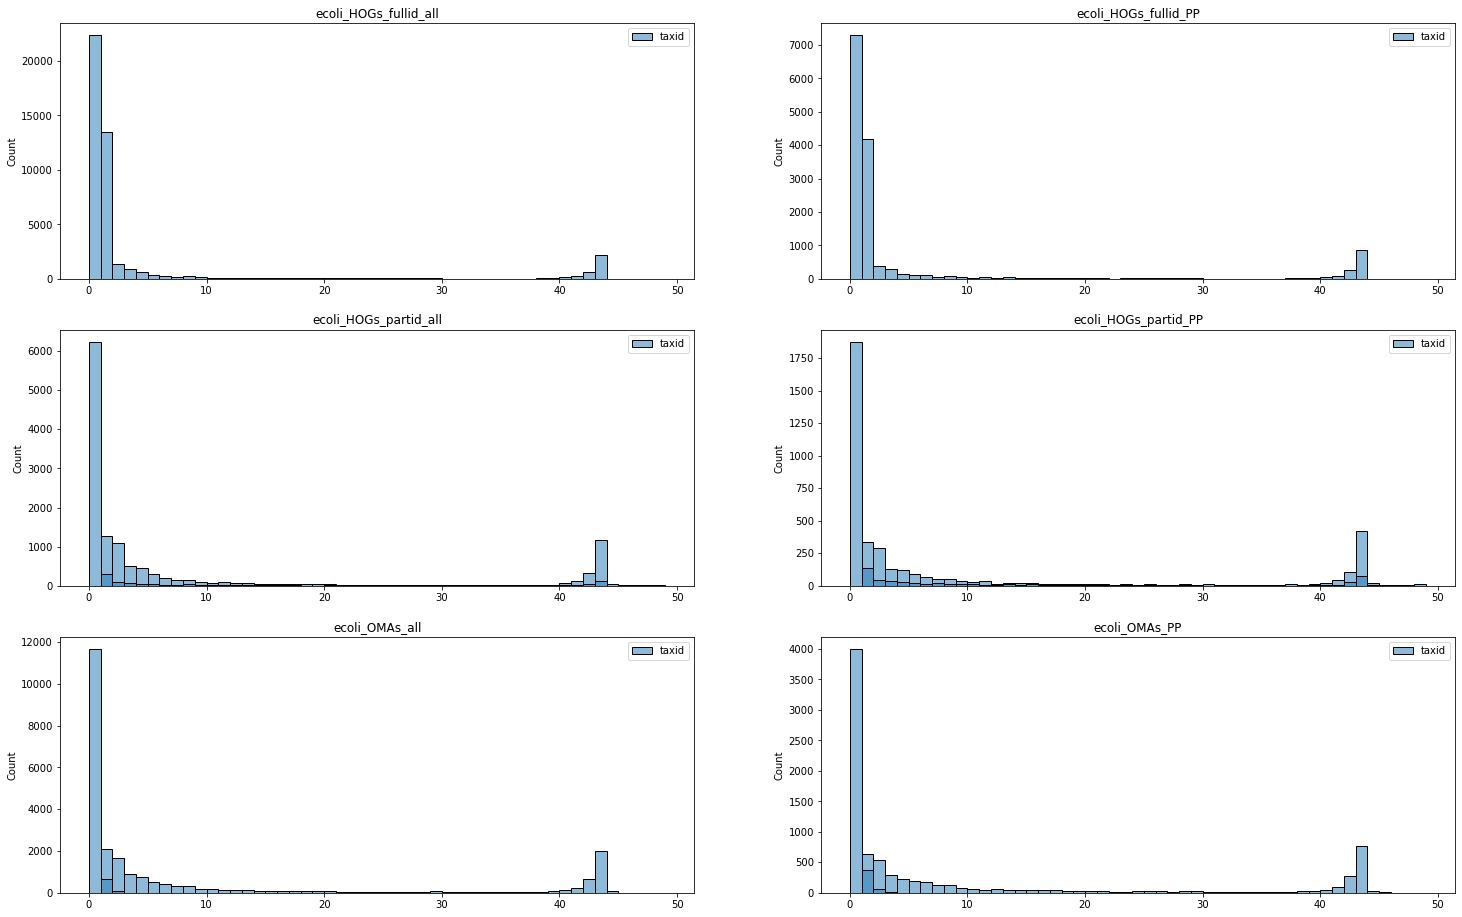

In [66]:
plt.rc("figure", figsize=(25, 16))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
for group, ax in zip(groups_list, [ax1, ax2, ax3, ax4, ax5, ax6]):
    print(group)
    data_g, data_m, _ = get_group_data(group)
    prot_count = data_g.groupby("hog").agg({"prot_id": lambda x: x.nunique()})
    paralog_count = data_g.groupby("hog").agg({"taxid": lambda x: x.size - x.nunique()})
    taxid_count = data_g.groupby("hog").agg({"taxid": lambda x: x.nunique()})
 
    print("Total number of groups: ", data_g.hog.nunique())
    print("Groups with 1 protein -", (prot_count.query("prot_id == 1").size))
    print("Groups with 43 proteins (core proteome) -", taxid_count.query("taxid == 43").size)
    print("Groups with < 43 proteins (accessory proteome) -", taxid_count.query("taxid < 43").size)
    print("Groups with > 43 proteins (paralogs included) -", prot_count.query("prot_id > 43").size)
    print("Total number of paralogs -", paralog_count.taxid.sum())
    print("Median of paralogs -", paralog_count.taxid.median())
    print("Mean of paralogs -", paralog_count.taxid.mean())
    print()
          
    sns.histplot(prot_count, bins=range(0, 50), ax=ax, alpha=0.5)
    sns.histplot(paralog_count, bins=range(0, 50), ax=ax, alpha=0.5)
    ax.set_title(group)

Distribution shows number of proteins in groups. Groups with partial HOG id (partid) may have more than 43 proteins, however axis is limited by 50.

**Dark color is number of paralogs**

## Proportion of proteins containing polyproline motifs

ecoli_HOGs_fullid_all
Average number of polyproline motifs per protein - 0.49393062856855396
Average number of polyproline motifs per protein normalized to the length - 0.156%

ecoli_HOGs_fullid_PP
Average number of polyproline motifs per protein - 1.3161485770968218
Average number of polyproline motifs per protein normalized to the length - 0.320%

ecoli_HOGs_partid_all
Average number of polyproline motifs per protein - 0.4939231744370888
Average number of polyproline motifs per protein normalized to the length - 0.156%

ecoli_HOGs_partid_PP
Average number of polyproline motifs per protein - 0.9004585473220836
Average number of polyproline motifs per protein normalized to the length - 0.231%

ecoli_OMAs_all
Average number of polyproline motifs per protein - 0.4939231744370888
Average number of polyproline motifs per protein normalized to the length - 0.156%

ecoli_OMAs_PP
Average number of polyproline motifs per protein - 1.2774489012633194
Average number of polyproline motifs per pro

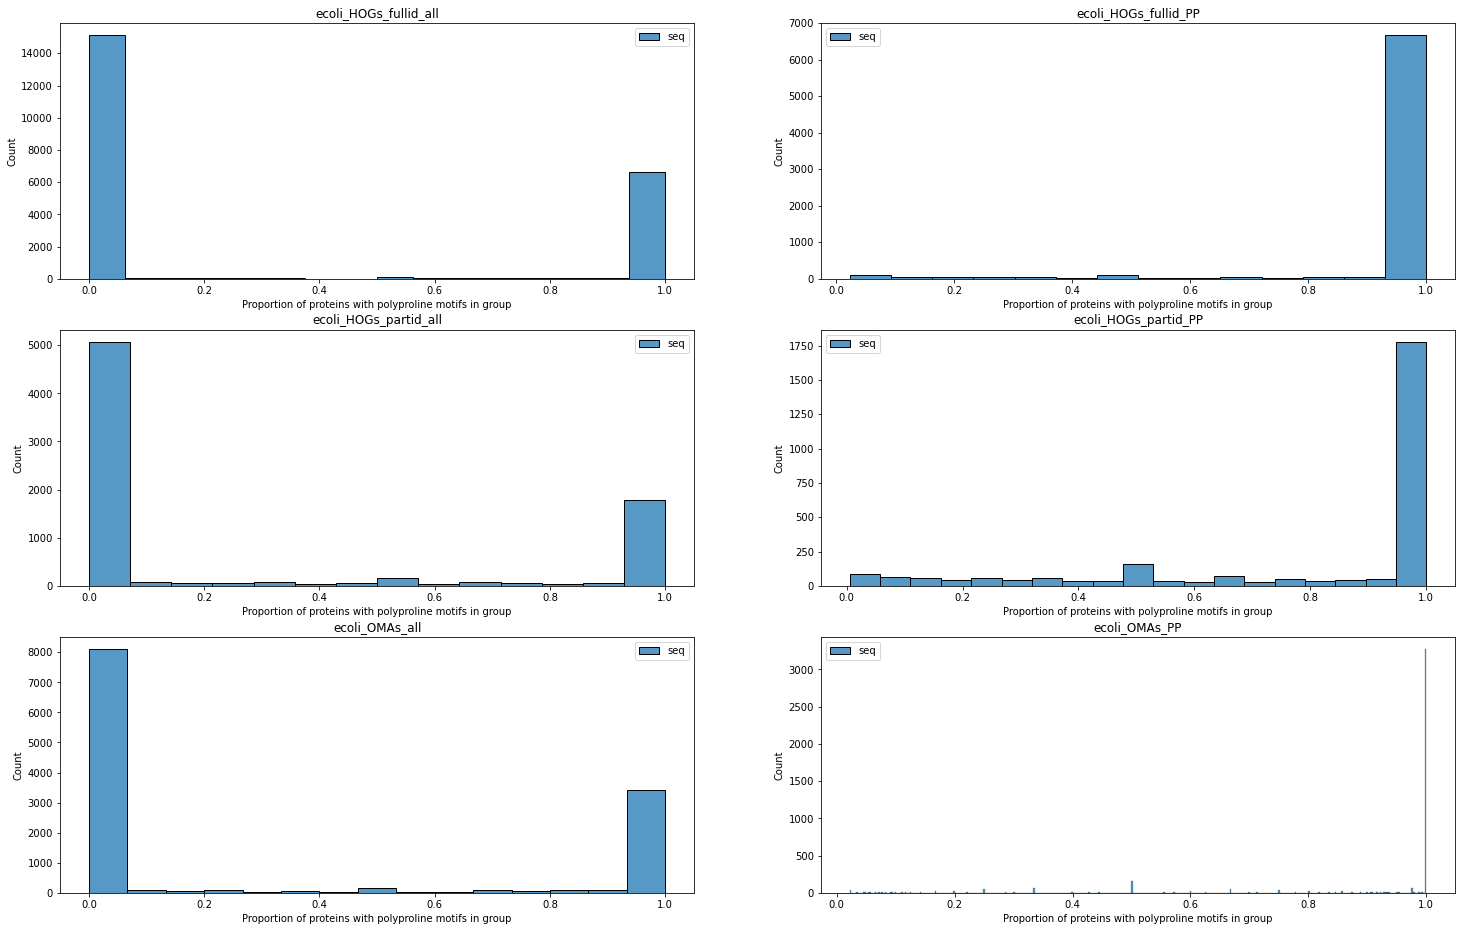

In [67]:
plt.rc("figure", figsize=(25, 16))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
for group, ax in zip(groups_list, [ax1, ax2, ax3, ax4, ax5, ax6]):
    data_g, data_m, data_p = get_group_data(group)
    data = data_g.merge(data_m, on="prot_id")
    data = data.merge(data_p, on="prot_id")
    with_pp_count = data.groupby("hog").agg({"seq": lambda x: sum(x != "NNNNN") / x.size})
    pp_per_protein = data.groupby("prot_id").agg({"seq": lambda x: sum(x != "NNNNN"), "length": "mean"})
    print(group)
    print("Average number of polyproline motifs per protein -", pp_per_protein.seq.mean())
    print("Average number of polyproline motifs per protein normalized to the length - {:.3f}%".format(
          pp_per_protein.seq.mean() / pp_per_protein.length.mean() * 100))
    print()
    sns.histplot(with_pp_count, ax=ax)
    ax.set_title(group)
    ax.set_xlabel("Proportion of proteins with polyproline motifs in group")

**ecoli_HOGs_fullid_PP** actually has proteins with no polyprolines, but there are few of them, so it is displayed like that.

## Motif strength distribution

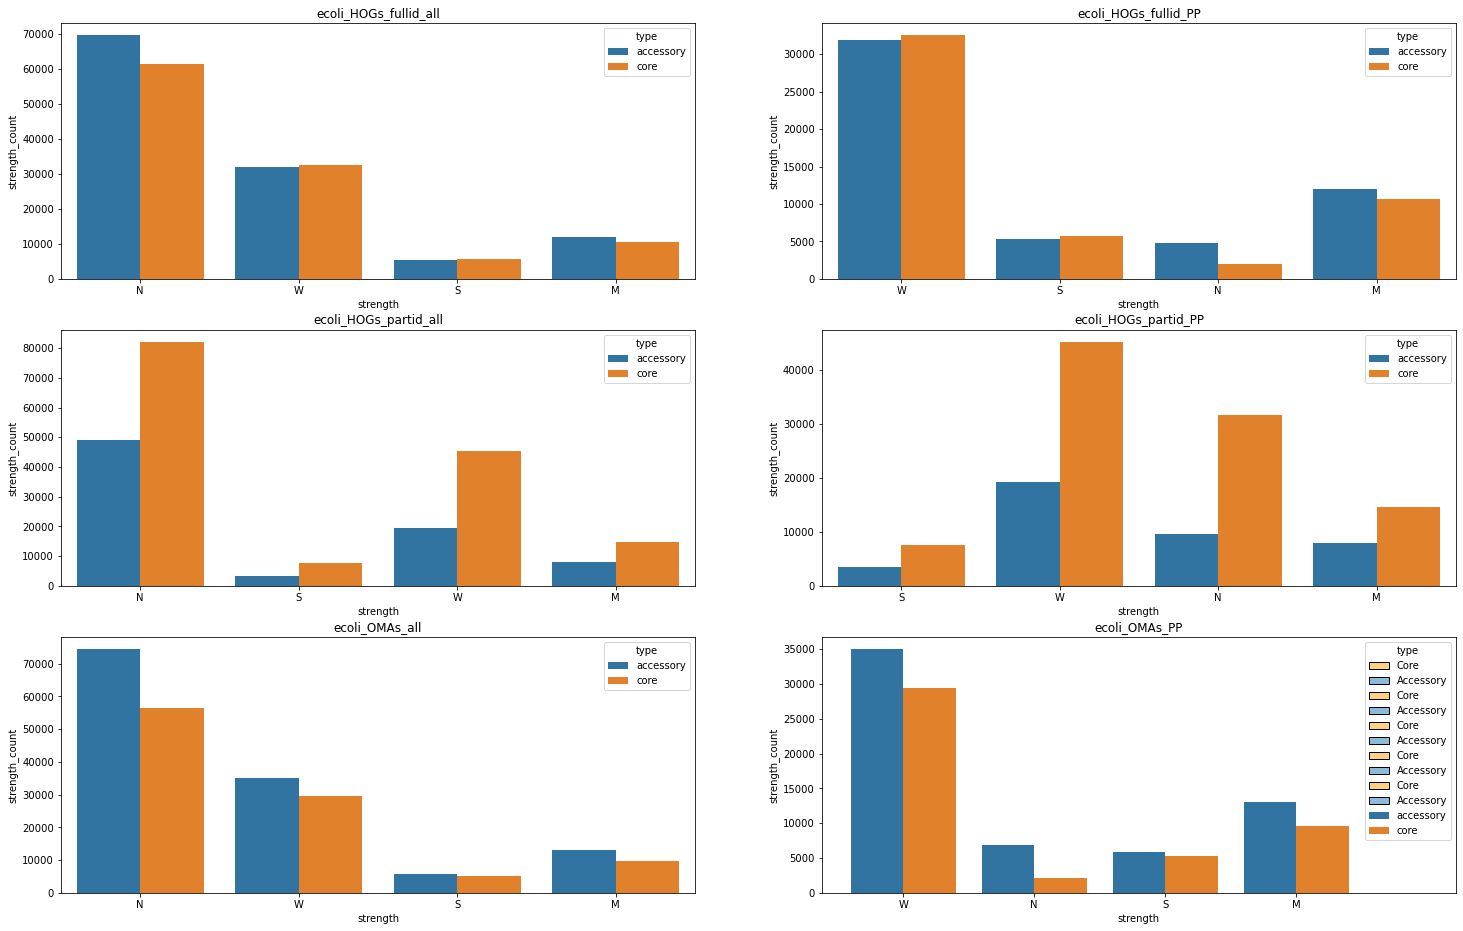

In [110]:
plt.rc("figure", figsize=(25, 16))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
for group, ax in zip(groups_list, [ax1, ax2, ax3, ax4, ax5, ax6]):
    data_g, data_m, data_p = get_group_data(group)
    data = data_g.merge(data_m, on="prot_id")
    core_proteome_groups = data_g.groupby("hog").agg({"taxid": lambda x: x.nunique()}).query("taxid == 43")
    accessory_proteome_groups = data_g.groupby("hog").agg({"taxid": lambda x: x.nunique()}).query("taxid < 43")
    accessory_proteome_groups.loc[:, "type"] = "accessory"
    core_proteome_groups.loc[:, "type"] = "core"
    data_types = data.merge(accessory_proteome_groups.append(core_proteome_groups).drop(columns=["taxid"]), on="hog", how="outer")
    strength_count = data_types.groupby(["strength", "type"]).agg({"prot_id": "count"})
    strength_count = strength_count.rename(columns={"prot_id": "strength_count"})
    data_types = data_types.merge(strength_count, on=["strength", "type"], how="outer")
    
    sns.barplot(x="strength", y="strength_count", hue="type", data=data_types, ax=ax)
    ax.set_title(group)

***N* is proteins without polyproline motifs**

## Number of prolines in motifs

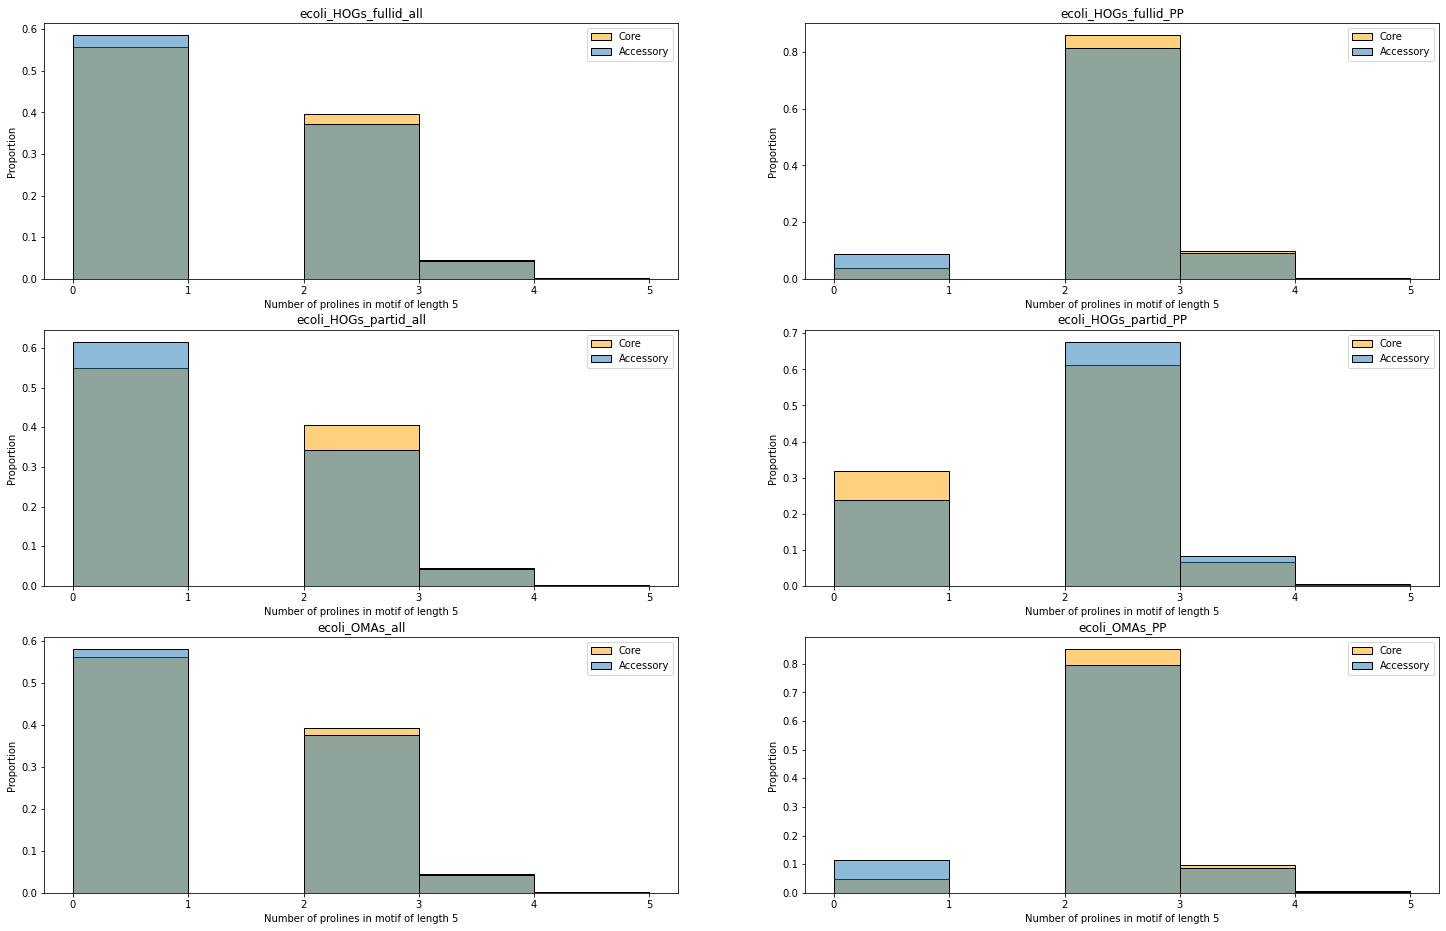

In [124]:
plt.rc("figure", figsize=(25, 16))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
for group, ax in zip(groups_list, [ax1, ax2, ax3, ax4, ax5, ax6]):
    data_g, data_m, data_p = get_group_data(group)
    data = data_g.merge(data_m, on="prot_id")
    core_proteome_groups = data_g.groupby("hog").agg({"taxid": lambda x: x.nunique()}).query("taxid == 43")
    accessory_proteome_groups = data_g.groupby("hog").agg({"taxid": lambda x: x.nunique()}).query("taxid < 43")
    accessory_proteome_groups.loc[:, "type"] = "accessory"
    core_proteome_groups.loc[:, "type"] = "core"
    data_types = data.merge(accessory_proteome_groups.append(core_proteome_groups).drop(columns=["taxid"]), on="hog", how="outer")
    #strength_count = data_types.groupby(["strength", "type"]).agg({"prot_id": "count"})
    #strength_count = strength_count.rename(columns={"prot_id": "strength_count"})
    #data_types = data_types.merge(strength_count, on=["strength", "type"], how="outer")
    
    data_types.loc[:, "proline_count"] = data_types.seq.apply(lambda x: x.count("P"))

    sns.histplot(data_types.query("type == 'core'").proline_count, label="Core",
                 stat="probability", color="orange", alpha=0.5, ax=ax, bins=range(6))
    sns.histplot(data_types.query("type == 'accessory'").proline_count, label="Accessory",
                 stat="probability", alpha=0.5, ax=ax, bins=range(6))
    ax.set_title(group)
    ax.set_xlabel("Number of prolines in motif of length 5")
    ax.set_ylabel("Proportion")
    ax.legend()

# Multiple sequence alignment analysis

## Analysis functions

In [3]:
def get_aligned_motifs(orthology_group_type, groups):
    """
    Returns information about all polyproline motifs in selected orthology groups.
    Input:
        1. orthology_group_type - type of groups (name of subdirectory in 'alignment')
        2. groups - list or other container containing groups of interest
    Output:
        1. Dictionary with keys corresponding to group_id. Values are list or pd.DataFrame.
        Each of dataframes represents single polyproline motif in all aligned sequences.
    """
    group_motifs = defaultdict(list)
    for hog in groups:
        motifs = set()
        # Select unique areas where motifs are aligned
        for rec in SeqIO.parse(f"alignment/{orthology_group_type}/{hog.replace(':', '')}.fasta", "fasta"):
            try:
                all_motifs = rec.description.split(" | ")[3].split(" ")
            except IndexError:
                continue
            for motif in all_motifs:
                seq, _, _, strength = motif.split(":")
                match = re.search(seq, str(rec.seq))
                if not match:
                    match = re.search(r'{}-*?{}-*?{}-*?{}-*?{}'.format(*seq), str(rec.seq))
                motifs.add(match.span())
        motif_data = [[] for _ in range(len(motifs))]
        # Extracting motifs info
        for rec in SeqIO.parse(f"alignment/{orthology_group_type}/{hog.replace(':', '')}.fasta", "fasta"):
            seq = str(rec.seq)
            try:
                all_motifs = list(map(lambda x: x.split(":"), rec.description.split(" | ")[3].split(" ")))
                native_motifs = dict(zip(map(lambda x: x[0], all_motifs), map(lambda x: x[1:], all_motifs)))
            except IndexError:
                all_motifs = []
                native_motifs = {}
            for idx, coords in enumerate(motifs):
                aligned_motif = seq[slice(*coords)]
                if (nm := aligned_motif.replace("-", "")) in native_motifs:
                    motif_data[idx].append((seq, aligned_motif, *coords, nm, *native_motifs[nm]))
                else:
                    motif_data[idx].append((seq, aligned_motif, *coords))
        motif_data = [pd.DataFrame(md, columns=["seq", "aligned_motif", "aligned_start", "aligned_end", "motif", "start", "end", "strength"][:len(md)]) for md in motif_data]
        for md in motif_data:
            group_motifs[hog].append(md)
    return group_motifs

def conserved_PP_proportion(group_motifs):
    total_PP = 0
    total_motifs = 0 
    for group in group_motifs:
        for md in group_motifs[group]:
            total_PP += sum(md.aligned_motif.apply(lambda x: "PP" in x.replace("-", ""))) / md.aligned_motif.size
            total_motifs += 1
    return total_PP / total_motifs

def substitutions(msa):
    return dict(filter(lambda x: x[1] > 0, dict(zip(msa.substitutions.alphabet, msa.substitutions["P"])).items()))

def complex_slice(string, coords, exclude=False):
    fragment = string
    if exclude:
        for coord in coords:
            if exclude:
                fragment = fragment[:coord[0]] + "@" * (coord[1] - coord[0]) + fragment[coord[1]+1:]
    else:
        fragment = "".join(map(lambda x: fragment[slice(*x)], coords))
    return fragment.replace("@", "")

def proline_substitutions(group_motifs, motif=True):
    all_substitutions = pd.Series(0, index=list("ACDEFGHIKLMNPQRSTVWY_"))
    for group in tqdm_notebook(group_motifs):
        motifs_coords = []
        for md in group_motifs[group]:
            motifs_coords.append((md.aligned_start.unique()[0], md.aligned_end.unique()[0]))
            if motif:
                msa = MultipleSeqAlignment(list(map(lambda x: SeqRecord(Seq(x.replace("-", "_"))), md.aligned_motif)))
                current_substitutions = pd.Series(substitutions(msa), index=list("ACDEFGHIKLMNPQRSTVWY_")).fillna(0)
                all_substitutions = all_substitutions.add(current_substitutions)
        if not motif:
            sequences = []
            for _, row in group_motifs[group][0].iterrows():
                sequences.append(Seq(complex_slice(row.seq, motifs_coords, exclude=True).replace("-", "_")))
            msa = MultipleSeqAlignment(list(map(lambda x: SeqRecord(x), sequences)))
            current_substitutions = pd.Series(substitutions(msa), index=list("ACDEFGHIKLMNPQRSTVWY_")).fillna(0)
            all_substitutions = all_substitutions.add(current_substitutions)
    return all_substitutions / all_substitutions.sum()

def percent_identity(seq1, seq2):
    matches = 0
    for s1, s2 in zip(seq1, seq2):
        if s1 == s2:
            matches += 1
    return matches / len(seq1) * 100

def grouped_mean_paiwise_identity(orthology_group_type, groups):
    group_identities = []
    for hog in groups:
        seq_identities = []
        records = list(SeqIO.parse(f"alignment/{orthology_group_type}/{hog.replace(':', '')}.fasta", "fasta"))
        sequences = tuple(map(lambda x: x.seq, records))
        for seq_pair in combinations(sequences, 2):
            seq_identities.append(percent_identity(*seq_pair))
        group_identities.append(mean(seq_identities))
    return group_identities

def insertion_sizes(group_motifs):
    all_insertion_lengths = []
    for hog in group_motifs:
        for md in group_motifs[hog]:
            insertion_lengths = md.aligned_motif.apply(lambda x: x.count("-"))
            all_insertion_lengths.append(insertion_lengths[insertion_lengths > 0].mean())
    return all_insertion_lengths

In [4]:
data_g, data_m, data_p = get_group_data("ecoli_HOGs_fullid_PP")
core_proteome_groups = data_g.groupby("hog").agg({"taxid": lambda x: x.nunique()}).query("taxid == 43")
target_groups_hogs_fullid_PP = core_proteome_groups.index

data_g, data_m, data_p = get_group_data("ecoli_OMAs_PP")
core_proteome_groups = data_g.groupby("hog").agg({"taxid": lambda x: x.nunique()}).query("taxid == 43")
target_groups_OMA_PP = core_proteome_groups.index

In [5]:
group_motifs_hogs_fullid_PP = get_aligned_motifs("ecoli_HOGs_fullid_PP", target_groups_hogs_fullid_PP)
group_motifs_OMA_PP = get_aligned_motifs("ecoli_OMAs_PP", target_groups_OMA_PP)

### Polyproline motifs conservatism

In [51]:
print("ecoli_HOGs_fullid_PP")
print("Proportion of conserved polyproline motifs in MSA -", conserved_PP_proportion(group_motifs_hogs_fullid_PP))
print()
print("ecoli_OMA_PP")
print("Proportion of conserved polyproline motifs in MSA -", conserved_PP_proportion(group_motifs_OMA_PP))

ecoli_HOGs_fullid_PP
Proportion of conserved polyproline motifs in MSA - 0.9126981187972153

ecoli_OMA_PP
Proportion of conserved polyproline motifs in MSA - 0.8967180728698373


### Proline substitutions

In [52]:
def substitutions(msa):
    return dict(filter(lambda x: x[1] > 0, dict(zip(msa.substitutions.alphabet, msa.substitutions["P"])).items()))

hogs_subst_motif = proline_substitutions(group_motifs_hogs_fullid_PP)
oma_subst_motif = proline_substitutions(group_motifs_OMA_PP)
hogs_subst_other = proline_substitutions(group_motifs_hogs_fullid_PP, motif=False)
oma_subst_other = proline_substitutions(group_motifs_OMA_PP, motif=False)

<ipython-input-48-a73057a7b112>:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for group in tqdm_notebook(group_motifs):


In [58]:
hogs_subst_motif.to_csv("hogs_fullid_PP_motif_subst.csv")
hogs_subst_other.to_csv("hogs_fullid_PP_other_subst.csv")
oma_subst_motif.to_csv("oma_PP_motif_subst.csv")
oma_subst_other.to_csv("oma_PP_other_subst.csv")

In [15]:
hogs_subst_motif = pd.read_csv("hogs_fullid_PP_motif_subst.csv", index_col=0, squeeze=True)
hogs_subst_other = pd.read_csv("hogs_fullid_PP_other_subst.csv", index_col=0, squeeze=True)
oma_subst_motif = pd.read_csv("oma_PP_motif_subst.csv", index_col=0, squeeze=True)
oma_subst_other = pd.read_csv("oma_PP_other_subst.csv", index_col=0, squeeze=True)

In [17]:
barplot_data_motif = pd.DataFrame(dict(Substitutions=[*hogs_subst_motif, *oma_subst_motif],
                                       Group=["HOG"] * hogs_subst_motif.size + ["OMA"] * oma_subst_motif.size,
                                       AA=list(hogs_subst_motif.index) + list(oma_subst_other.index)))

barplot_data_other = pd.DataFrame(dict(Substitutions=[*hogs_subst_other, *oma_subst_other],
                                       Group=["HOG"] * hogs_subst_other.size + ["OMA"] * oma_subst_other.size,
                                       AA=list(hogs_subst_other.index) + list(oma_subst_other.index)))

Text(0, 0.5, 'Substitution frequency')

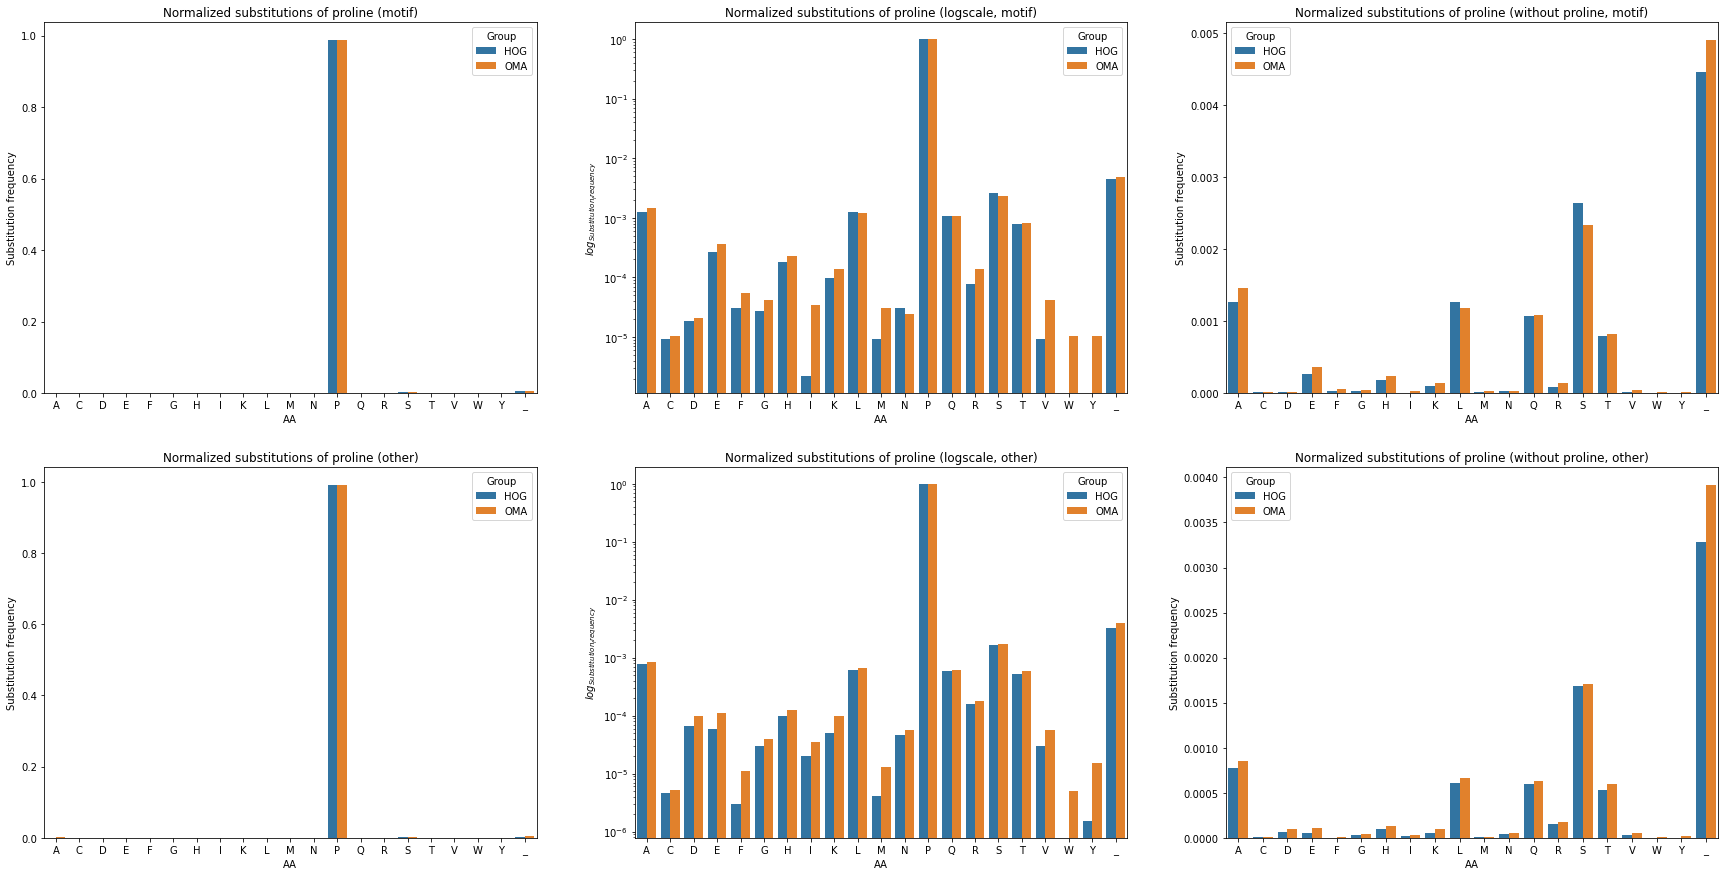

In [18]:
fix, ax = plt.subplots(2, 3, figsize=(30, 15))
sns.barplot(x="AA", y="Substitutions", hue="Group", data=barplot_data_motif, ax=ax[0][0])
ax[0][0].set_title("Normalized substitutions of proline (motif)")
ax[0][0].set_ylabel("Substitution frequency")

sns.barplot(x="AA", y="Substitutions", hue="Group", data=barplot_data_motif, ax=ax[0][1])
ax[0][1].set_title("Normalized substitutions of proline (logscale, motif)")
ax[0][1].set_yscale("log")
ax[0][1].set_ylabel("$log_{Substitution_frequency}$")

sns.barplot(x="AA", y="Substitutions", hue="Group", data=barplot_data_motif.query("AA != 'P'"), ax=ax[0][2])
ax[0][2].set_title("Normalized substitutions of proline (without proline, motif)")
ax[0][2].set_ylabel("Substitution frequency")

sns.barplot(x="AA", y="Substitutions", hue="Group", data=barplot_data_other, ax=ax[1][0])
ax[1][0].set_title("Normalized substitutions of proline (other)")
ax[1][0].set_ylabel("Substitution frequency")

sns.barplot(x="AA", y="Substitutions", hue="Group", data=barplot_data_other, ax=ax[1][1])
ax[1][1].set_title("Normalized substitutions of proline (logscale, other)")
ax[1][1].set_yscale("log")
ax[1][1].set_ylabel("$log_{Substitution_frequency}$")

sns.barplot(x="AA", y="Substitutions", hue="Group", data=barplot_data_other.query("AA != 'P'"), ax=ax[1][2])
ax[1][2].set_title("Normalized substitutions of proline (without proline, other)")
ax[1][2].set_ylabel("Substitution frequency")

### Sequence pairwise identity in groups

In [77]:
hog_identities = grouped_mean_paiwise_identity("ecoli_HOGs_fullid_PP", target_groups_hogs_fullid_PP)
oma_identities = grouped_mean_paiwise_identity("ecoli_OMAs_PP", target_groups_OMA_PP)

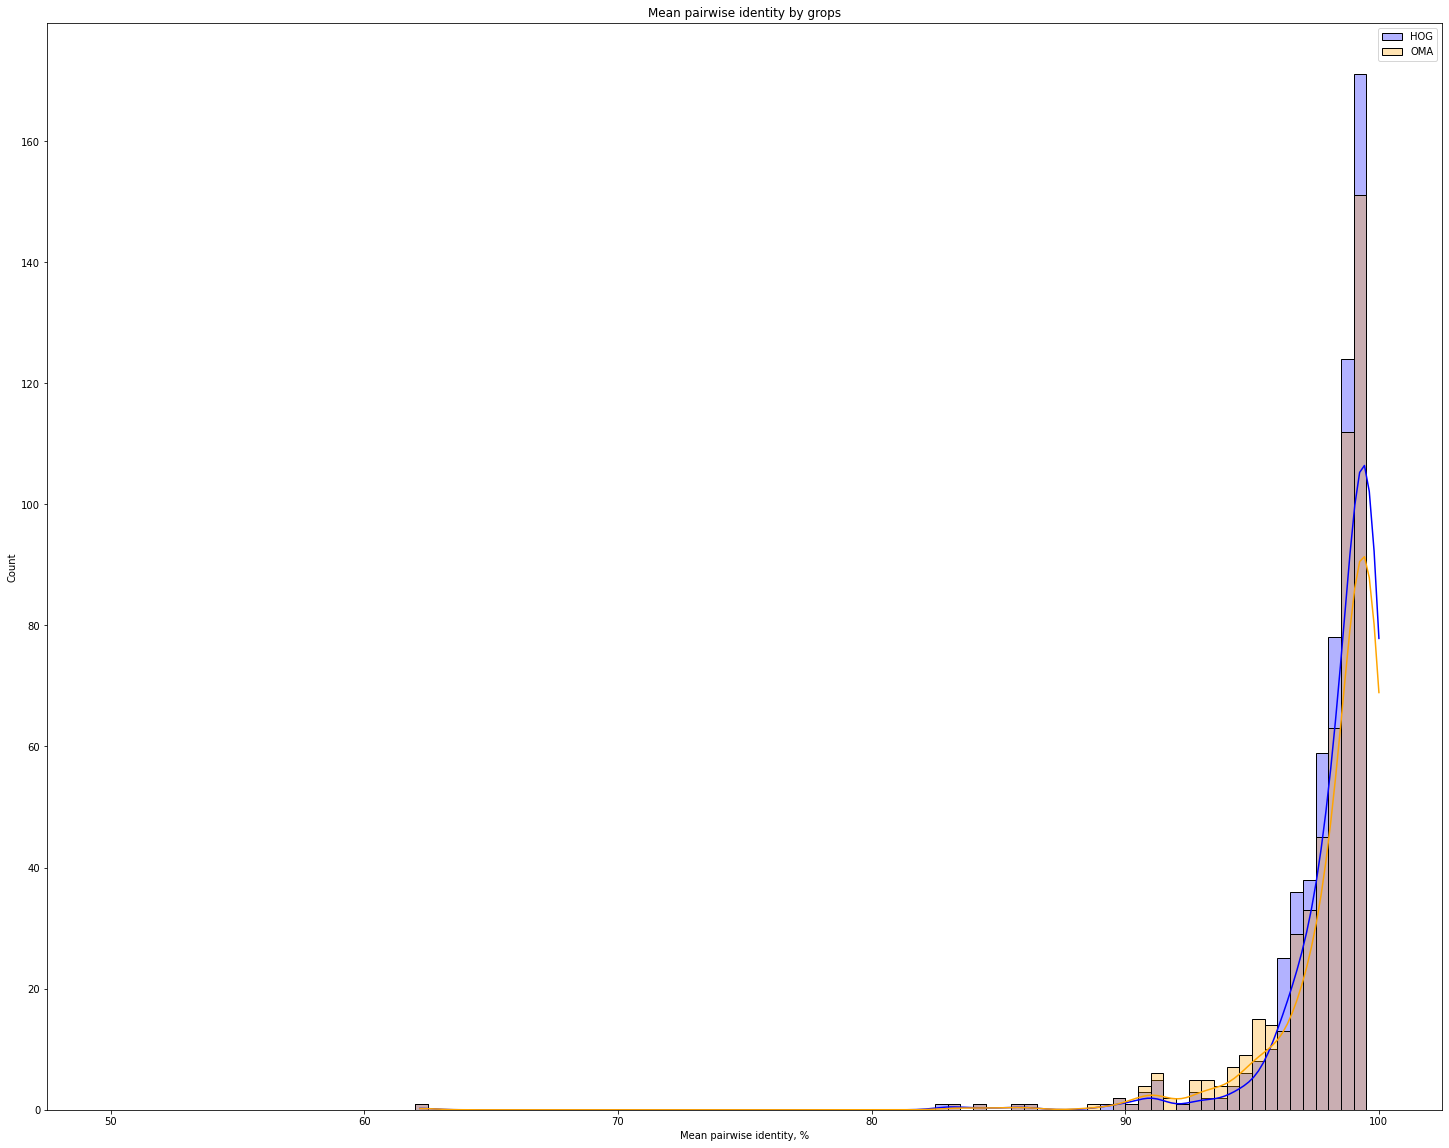

In [78]:
plt.rc("figure", figsize=(25, 20))
sns.histplot(hog_identities, bins=[50 + i * 0.5 for i in range(100)], alpha=0.3, color="blue", label="HOG", kde=True)
sns.histplot(oma_identities, bins=[50 + i * 0.5 for i in range(100)], alpha=0.3, color="orange", label="OMA", kde=True)
plt.title("Mean pairwise identity by grops")
plt.xlabel("Mean pairwise identity, %")
plt.legend()

### Insertion size distribution

In [79]:
nan = float("nan")
hog_inssize = insertion_sizes(group_motifs_hogs_fullid_PP)
oma_inssize = insertion_sizes(group_motifs_OMA_PP)
insert_distrib_hog = list(filter(lambda x: x != nan, hog_inssize))
insert_distrib_oma = list(filter(lambda x: x != nan, oma_inssize))

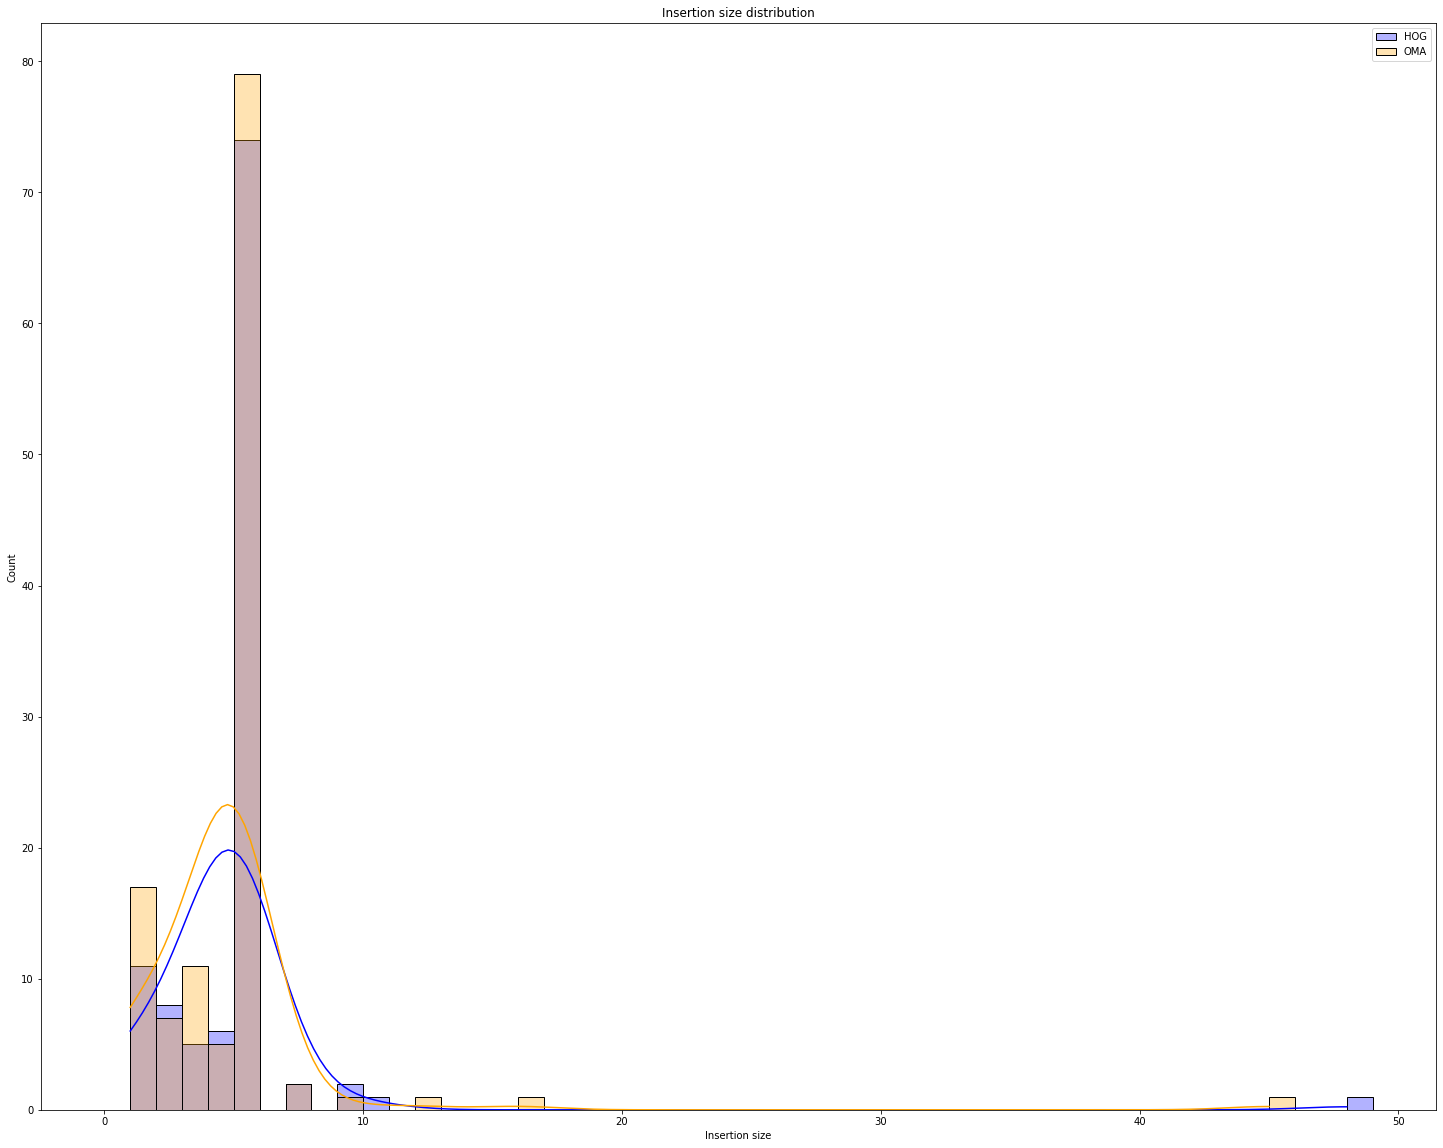

In [80]:
plt.rc("figure", figsize=(25, 20))
sns.histplot(insert_distrib_hog, bins=range(50), alpha=0.3, color="blue", label="HOG", kde=True)
sns.histplot(insert_distrib_oma, bins=range(50), alpha=0.3, color="orange", label="OMA", kde=True)
plt.title("Insertion size distribution")
plt.xlabel("Insertion size")
plt.legend()